# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [6]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

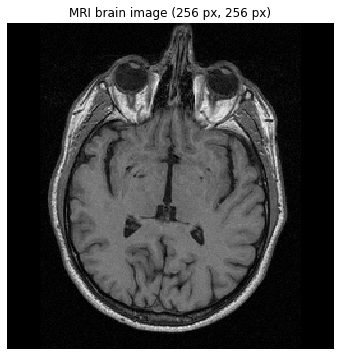

In [7]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

im_h, im_w = brain_im.shape
dpi = plt.rcParams['figure.dpi']
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


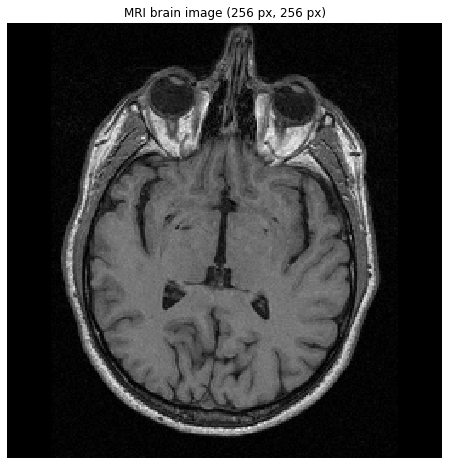

In [8]:
%load_ext autoreload
%autoreload 2

from helpers import *

plot_brain(brain_im, original_size = False, img_size = (8,8))

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

- Histogram equalization
- Median filter is good keeping the countours
- Enhance high frequencies

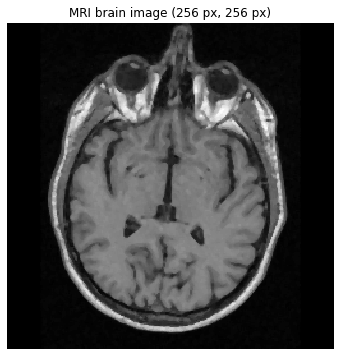

In [10]:
import skimage.filters

median_filtered = skimage.filters.median(brain_im)

plot_brain(median_filtered, original_size=False)

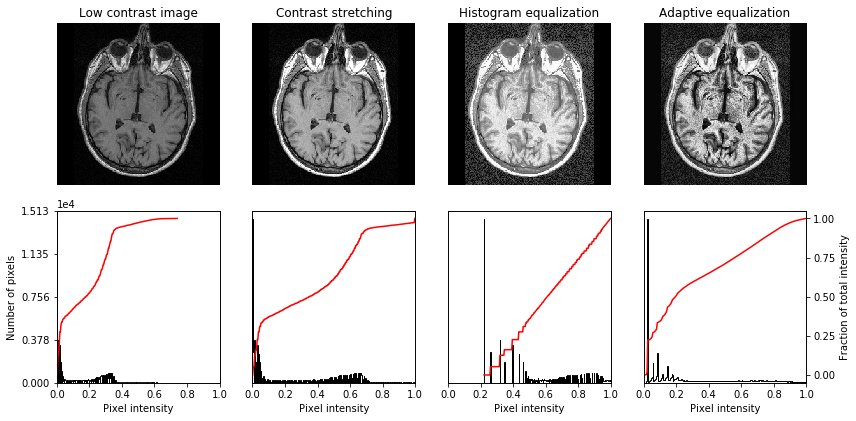

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


# Load an example image
img = brain_im

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 6))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

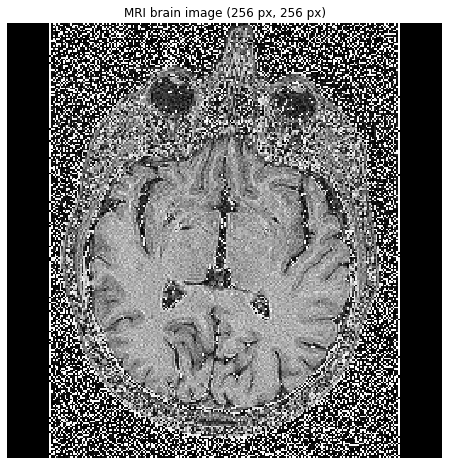

In [90]:
from scipy import ndimage

img = brain_im

h1  = np.array([[0, -1, 0],
               [-1, 6, -1],
               [0, -1, 0]])

h2  = np.array([[-1, -1, -1],
               [-1, 12, -1],
               [-1, -1, -1]])

h3  = np.array([[1, -2, 1],
               [-2, 10, -2],
               [1, -2, 1]])

im_hi = ndimage.convolve(img, h1)

plot_brain(im_hi, original_size=False, img_size = (8,8))

<ipython-input-19-1b6ec909d0fb>:9: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(im, cmap='gray')


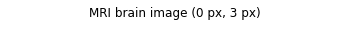

In [19]:
from skimage import data, feature, exposure
im = im_hi
#im = exposure.equalize_hist(img)  # improves detection
im = feature.blob_log(im, threshold = 100)

im_h, im_w = im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

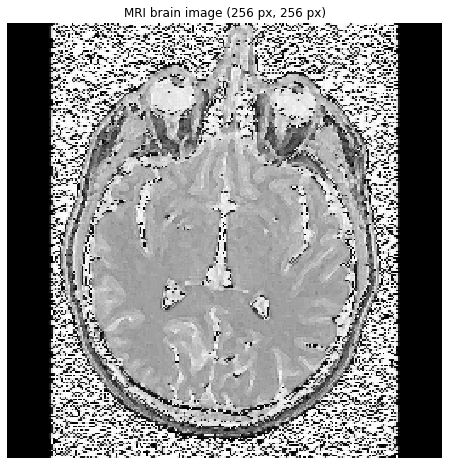

In [121]:
from scipy import ndimage

im = median_filtered

im = ndimage.gaussian_laplace(im, sigma= 0.5)
log = im

plot_brain(log, original_size=False, img_size = (8,8))

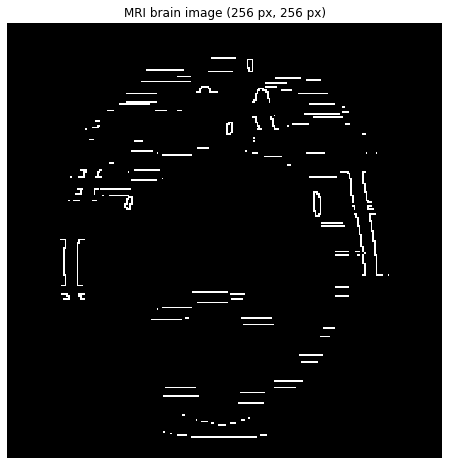

In [119]:
from scipy import ndimage

im = median_filtered
LoG = ndimage.gaussian_laplace(im, 4)
thres = np.absolute(LoG).mean() *0.5
output = np.zeros(LoG.shape)
w = output.shape[1]
h = output.shape[0]

for y in range(1, h - 1):
    for x in range(1, w - 1):
        patch = LoG[y-1:y+2, x-1:x+2]
        p = LoG[y, x]
        maxP = patch.max()
        minP = patch.min()
        if (p > 0):
            zeroCross = True if minP < 0 else False
        else:
            zeroCross = True if maxP > 0 else False
        if ((maxP - minP) > thres) and zeroCross:
            output[y, x] = 1

plot_brain(output, original_size=False, img_size = (8,8))

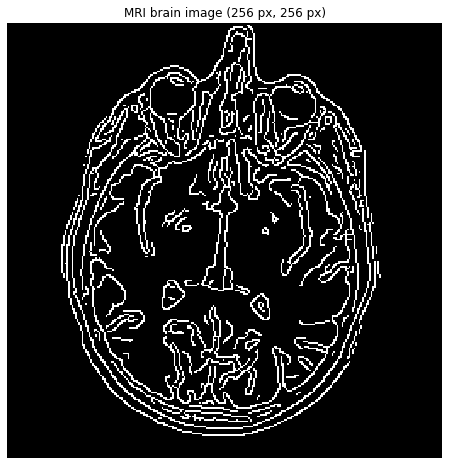

In [122]:
from skimage import feature

canny_filtered = feature.canny(median_filtered, sigma=0.7)

plot_brain(canny_filtered, original_size=False, img_size = (8,8))


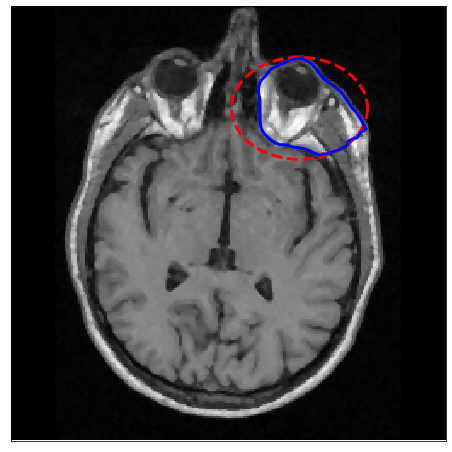

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


img = median_filtered
img = rgb2gray(img)

s = np.linspace(0, 2*np.pi, 400)
r = 60 + 30*np.sin(s)
c = 170 + 40*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 1),
                       init, alpha=0.05, beta=0.01, gamma=0.01,
                       coordinates='rc',)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [9]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


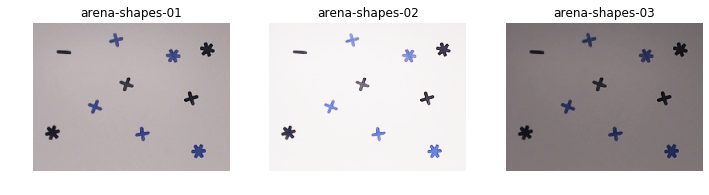

In [10]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion